# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import *

In [2]:
# Test parameters
runs = 50
epochs = 100
recommendation_size = 10

In [3]:
good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.952740832015791


In [5]:
class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        return sum([payout_function() for i in range(n)]) / n

In [7]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 593.6399999999996
random: 281.03999999999996


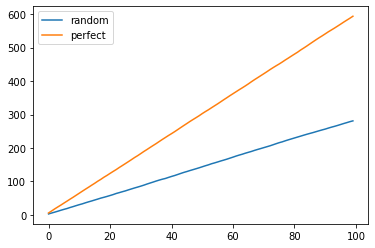

In [9]:
runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.04
random: 2.44


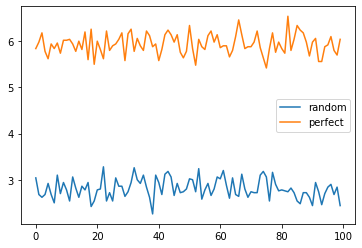

In [10]:
runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [24]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        sorted_arms = sorted(self.arm_ids, key=lambda arm_id: self.payouts_per_recommendation[arm_id], reverse=True)
        randomed_arms = sample(self.arm_ids, len(self.arm_ids))
        
        recommendation = []
        for i in range(size):
            taken = 0
            if random() <= self.epsilon:
                taken = randomed_arms[i]
                if taken in recommendation:
                    for j in range(i+1, len(randomed_arms)):
                        to_take = randomed_arms[j]
                        if to_take not in recommendation:
                            taken = to_take
                            break
                    if taken in recommendation:
                        for j in range(i-1, -1, -1):
                            to_take = randomed_arms[j]
                            if to_take not in recommendation:
                                taken = to_take
                                break
                recommendation.append(taken)
            else:
                taken = sorted_arms[i]
                if taken in recommendation:
                    for j in range(i+1, len(sorted_arms)):
                        to_take = sorted_arms[j]
                        if to_take not in recommendation:
                            taken = to_take
                            break
                    if taken in recommendation:
                        for j in range(i-1, -1, -1):
                            to_take = sorted_arms[j]
                            if to_take not in recommendation:
                                taken = to_take
                                break
                recommendation.append(taken)
            
            self.recommended_rates[taken] += 1
        
        return recommendation
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [25]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 1
    
    def recommend(self, size):
        sorted_arms = sorted(self.arm_ids, key=lambda arm_id: self.payouts_per_recommendation[arm_id] + self._optimism(arm_id), reverse=True)
        sorted_arms_size = sorted_arms[:size]
        
        for arm in sorted_arms_size:
            self.recommended_rates[arm] += 1
        
        self.n += size
        return sorted_arms_size
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [26]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        sorted_arms = sorted(self.arm_ids, key=lambda arm_id: betavariate(self.a[arm_id], self.b[arm_id]), reverse=True)
        return sorted_arms[:size]
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [27]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [ ]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10



Aggregated results:

ts_5_1: 6.38
ucb_10: 6.36
ts_1_20: 6.2
ts_5_5: 6.2
egreedy_0.01: 6.16
ts_1_10: 6.16
ts_5_50: 6.16
ts_50_1: 6.14
ts_5_20: 6.12
perfect: 6.1
ts_1_50: 6.04
ts_10_50: 6.04
ts_1_1: 6.02
ts_5_10: 5.98
ts_1_5: 5.94
egreedy_0.05: 5.9
ts_20_1: 5.9
ts_10_20: 5.84
ts_50_5: 5.76
egreedy_0.1: 5.72
ts_10_1: 5.7
ts_10_10: 5.7
ts_20_5: 5.66
ucb_1: 5.58
ts_20_20: 5.56
ts_10_5: 5.48
egreedy_0.25: 5.28
ts_20_10: 5.24
ts_20_50: 5.16
ts_50_20: 5.06
ts_50_50: 4.88
ucb_0.01: 4.74
ucb_0.1: 4.5
ts_50_10: 4.5
random: 2.74


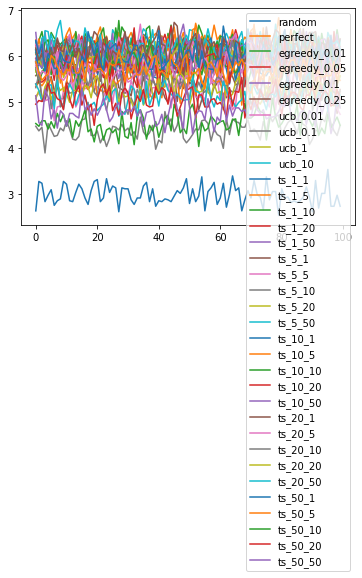

In [26]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 626.7199999999997
egreedy_0.01: 624.9599999999998
ucb_10: 624.7
ts_5_50: 621.8399999999998
ts_1_50: 616.7400000000001
ts_20_1: 616.4199999999997
ts_1_5: 614.3200000000002
ts_1_10: 613.5399999999998
ts_5_1: 610.6000000000003
ts_1_20: 610.2600000000003
ts_5_5: 609.1799999999998
ts_1_1: 608.48
ts_50_1: 600.4799999999999
ts_5_20: 595.8600000000002
ts_5_10: 593.14
egreedy_0.05: 590.7200000000001
ts_10_50: 585.12
egreedy_0.1: 582.8199999999998
ts_10_10: 582.7799999999999
ucb_1: 579.78
ts_10_20: 576.2800000000001
ts_10_1: 573.0199999999999
ts_50_5: 571.26
ts_20_5: 570.48
ts_10_5: 544.6200000000001
egreedy_0.25: 535.78
ts_20_10: 528.54
ts_20_20: 524.3399999999999
ucb_0.01: 523.14
ts_20_50: 513.32
ts_50_20: 508.09999999999997
ts_50_50: 478.3999999999998
ts_50_10: 454.96
ucb_0.1: 441.49999999999994
random: 299.1200000000001


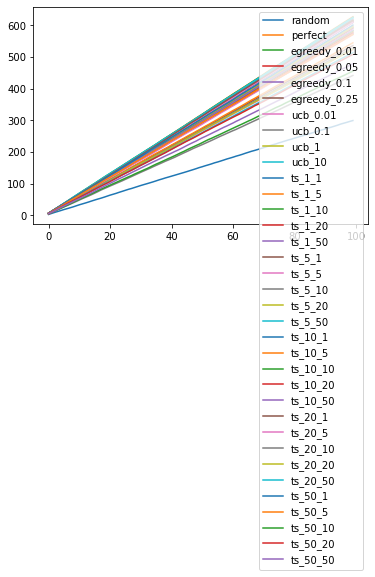

In [27]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [28]:
def relevant(recommendation: List[Arm]) -> int:
    return sum(1 for r in recommendation if r.arm_id.startswith('good_'))

all_relevant = relevant(arms.values())

In [29]:
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / all_relevant

In [30]:
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [31]:
testing_bandits = [
    Perfect('perfect', arm_ids, arms),
    Random('random', arm_ids),
    EGreedy('egreedy_0.01', arm_ids, 0.01),
    UCB('ucb_0.01', arm_ids, 0.01),
    ThompsonSampling('ts_1_1', arm_ids, 1, 1)
]
k_vals = [3, 5, 10]
samples = 10

for bandit in testing_bandits:
    print(f"Testing {bandit.bandit_id}")
    for k in k_vals:
        precision_sum = 0
        recall_sum = 0
        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precision_sum += precision_at_k(recommendation, k)
            recall_sum += recall_at_k(recommendation, k, all_relevant)
        avg_precision = precision_sum / samples
        avg_recall = recall_sum / samples
        print(f"Precision@{k}: {avg_precision}, Recall@{k}: {avg_recall}")

Testing perfect
Precision@3: 1.0, Recall@3: 0.29999999999999993
Precision@5: 1.0, Recall@5: 0.5
Precision@10: 1.0, Recall@10: 1.0
Testing random
Precision@3: 0.1, Recall@3: 0.030000000000000006
Precision@5: 0.04, Recall@5: 0.02
Precision@10: 0.12, Recall@10: 0.12
Testing egreedy_0.01
Precision@3: 0.9666666666666668, Recall@3: 0.2899999999999999
Precision@5: 0.9800000000000001, Recall@5: 0.49000000000000005
Precision@10: 0.9800000000000001, Recall@10: 0.9800000000000001
Testing ucb_0.01
Precision@3: 0.1, Recall@3: 0.03
Precision@5: 0.1, Recall@5: 0.05
Precision@10: 0.1, Recall@10: 0.1
Testing ts_1_1
Precision@3: 0.1, Recall@3: 0.030000000000000006
Precision@5: 0.06000000000000001, Recall@5: 0.030000000000000006
Precision@10: 0.12000000000000002, Recall@10: 0.12000000000000002
